In [5]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import uuid

In [47]:
# Load the dataset
csv_path = 'NL_Housing_Data.csv'
nl_data = pd.read_csv(csv_path)
Avg_Asking_Price = nl_data['Asking_Price'].mean()

# Encode categorical features
mappings = {}
for col in ['Provincie', 'Locatie', 'Type_of_building', 'BadKamers', 'Energy_label', 'Erfpacht?', 'Parking']:
    mean_prices = nl_data.groupby(col)['Asking_Price'].mean()
    sorted_types = mean_prices.sort_values(ascending = False).index
    col_mapping = {btype: i for i, btype in enumerate(sorted_types)}
    mappings[col] = col_mapping
    nl_data[col + '_encoded'] = nl_data[col].map(col_mapping)
#Anonymize Addresses
def anon(df, column_name):
    uvalues = df[column_name].unique()
    mapping = {value : str(uuid.uuid4()) for value in uvalues}
    df[column_name] = df[column_name].map(mapping)
    return df
anon(nl_data, 'Adres')    
# Feature engineering
nl_data['Age'] = 2024-nl_data['Year_of_Construction']
nl_data['price_per_m2'] = nl_data['Asking_Price']/(nl_data['Living_AreaSize(m2)'])
nl_data_final = nl_data
del nl_data

,Adres,Provincie,Locatie,Year_of_Construction,Type_of_Construction,Type_of_building,No_of_rooms,Living_AreaSize(m2),Floors,Inhoud(m3),...,Asking_Price,Provincie_encoded,Locatie_encoded,Type_of_building_encoded,BadKamers_encoded,Energy_label_encoded,Erfpacht?_encoded,Parking_encoded,Age,price_per_m2
0,6f455fe9-fe4b-4bfb-98de-017175d120f4,Noord Holland,Amsterdam,1968,Existing Construction,Gallery Apartment,2,56,1,181,...,335000,0,75,11,10,8,1,7,56,5982.142857
1,15cf21d9-93de-41fd-8c3b-570cc437aea4,Utrecht,De Bilt,1933,Existing Construction,Single-family home,4,130,3,452,...,795000,1,3,8,10,4,0,1,91,6115.384615
2,8acec541-05ae-473c-a7cf-6d3839922dbb,Noord Holland,Amstelveen,1971,Existing Construction,Gallery Apartment,4,92,1,277,...,445000,0,9,11,10,7,0,7,53,4836.956522
3,ce54e07c-6e84-4dd9-90e9-1bb411b51d9e,Noord Holland,Amsterdam,1984,Existing Construction,Single-family home,4,106,2,385,...,595000,0,75,8,10,4,1,7,40,5613.207547
4,5ca72331-88b1-4de9-8d46-535026b2ad9b,Noord Holland,Amstelveen,1958,Existing Construction,Single-family home,5,131,3,416,...,995000,0,9,8,7,4,0,1,66,7595.419847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,1e8f75b2-ccee-4306-90d3-f9027c3b85b1,Flevoland,Rutten,1955,Existing Construction,Farmhouse,8,163,3,1923,...,759000,5,110,3,10,9,0,0,69,4656.441718
662,5571d75e-49de-46e4-b868-bec0cc522d73,Flevoland,Luttelgeest,1952,Existing Construction,Farmhouse,13,319,3,1067,...,875000,5,21,3,7,7,0,0,72,2742.946708
663,58ddb4ce-cb47-488d-b9fe-b1275af2785a,Limburg,Ittervoort,1976,Existing Construction,Farmhouse,10,255,2,1300,...,795000,11,32,3,11,7,0,0,48,3117.647059
664,dbd9dcbb-6cd4-4618-afdb-cab81d1f320f,Limburg,Meijel,1901,Existing Construction,Farmhouse,6,257,2,1122,...,650000,11,57,3,10,5,0,0,123,2529.182879


In [23]:
# Prepare data for modeling
y = nl_data_final.Asking_Price
features = ['Age', 'Type_of_building_encoded', 'No_of_rooms','Floors', 'Living_AreaSize(m2)', 
            'Energy_label_encoded', 'Erfpacht?_encoded', 
            'SlaapKamers','VvE per maand','Inhoud(m3)','Outdoor_Space(m2)',
            'BadKamers_encoded','Parking_encoded','Provincie_encoded','Locatie_encoded','price_per_m2']
X = nl_data_final[features]

# Split data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=42)


In [25]:
# --- Decision Tree Model ---

# Train initial Decision Tree model
NL_Model = DecisionTreeRegressor(random_state = 42)

NL_Model.fit(train_X,train_y)

val_pred = NL_Model.predict(val_X)
val_mae = mean_absolute_error(val_pred, val_y)
print("Validation MAE: {:,.0f}".format(val_mae))

Validation MAE: 75,025


In [27]:
# Hyperparameter tuning for Decision Tree
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, random_state = 42)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)
leaf_nodes = [5,10,15,20,25,30,35,40,45,50,75,100,150,200,250,350,400,500]
for max_leaf_nodes in leaf_nodes:
    mae_model = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print (max_leaf_nodes,mae_model)


param_grid_dt = {'max_depth' : [3,5,7,10,12],
                 'min_samples_split' : [2,5,10],
                 'min_samples_leaf' : [1,2,4,6,10,12]  
}

grid_search_dt = GridSearchCV(estimator = NL_Model,
                              param_grid = param_grid_dt,
                              scoring = 'neg_mean_absolute_error',
                              cv = 5)
grid_search_dt.fit(train_X, train_y)
print("Best parameters for Decision Tree Model:", grid_search_dt.best_params_)

5 152240.82388070787
10 118067.0580031874
15 112065.70564666604
20 98378.60588729646
25 92403.3865272273
30 93256.14558401251
35 88567.74766546977
40 86410.53834732997
45 89121.81972160547
50 89648.09338068959
75 86050.69267935534
100 81766.09228322069
150 79319.59366980325
200 79168.61170516112
250 78468.9121756487
350 78807.53493013972
400 78894.61077844311
500 78860.4491017964
Best parameters for Decision Tree Model: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [28]:
# Evaluate best Decision Tree model
best_model_dt = grid_search_dt.best_estimator_
val_pred_dt = best_model_dt.predict(val_X)
val_mae_dt = mean_absolute_error(val_y,val_pred_dt)
val_mse_dt = mean_squared_error(val_y, val_pred_dt)
val_rmse_dt = np.sqrt(val_mse_dt)
val_r2_dt = r2_score(val_y, val_pred_dt)
print("Average Asking Price:{:,.0f}".format(Avg_Asking_Price))
print("Validation MAE for best model Decision Tree: {:,.0f}".format(val_mae_dt))
print("Validation MSE for best model Decision Tree: {:,.0f}".format(val_mse_dt))
print("Validation RMSE for best model Decision Tree: {:,.0f}".format(val_rmse_dt))
print("Validation R^2 for best model Decision Tree: {:.4f}".format(val_r2_dt))

Average Asking Price:579,426
Validation MAE for best model Decision Tree: 73,851
Validation MSE for best model Decision Tree: 56,310,783,760
Validation RMSE for best model Decision Tree: 237,299
Validation R^2 for best model Decision Tree: 0.7023


In [31]:
# --- Random Forest Model ---

# Train initial Random Forest model
NL_Model_RF = RandomForestRegressor(random_state = 42)

NL_Model_RF.fit(train_X,train_y)

val_pred_rf = NL_Model_RF.predict(val_X)
val_mae_rf = mean_absolute_error(val_pred_rf, val_y)

print("Validation MAE RF: {:,.0f}".format(val_mae_rf))

# Hyperparameter tuning for Random Forest
grid_param_rf = {'n_estimators' : [50,100,150,200],
                 'max_depth' : [None, 5, 10],
                 'min_samples_split' : [2,4,6,8,10]
}

grid_search_rf = GridSearchCV(estimator = NL_Model_RF,
                              param_grid = grid_param_rf,
                              scoring = 'neg_mean_absolute_error',
                              cv = 5)

grid_search_rf.fit(train_X, train_y)
print("Best parameters for Random Forest Tree Model:", grid_search_rf.best_params_)  

Validation MAE RF: 45,238
Best parameters for Random Forest Tree Model: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150}


In [33]:
# Evaluate best Random Forest model
best_model_rf = grid_search_rf.best_estimator_
val_pred_rf_best = best_model_rf.predict(val_X)
val_mae_rf_best = mean_absolute_error(val_pred_rf_best,val_y)
val_mse_rf_best = mean_squared_error(val_y, val_pred_rf_best)
val_rmse_rf_best = np.sqrt(val_mse_rf_best)
val_r2_rf_best = r2_score(val_y, val_pred_rf_best)
print("Average Asking Price:{:,.0f}".format(Avg_Asking_Price))
print("Best Random Forest Model MAE:{:,.0f}".format(val_mae_rf_best))
print("Best Random Forest Model MSE:{:,.0f}".format(val_mse_rf_best))
print("Best Random Forest Model RMSE:{:,.0f}".format(val_rmse_rf_best))
print("Best Random Forest Model R^2:{:.4f}".format(val_r2_rf_best))

Average Asking Price:579,426
Best Random Forest Model MAE:47,838
Best Random Forest Model MSE:32,459,797,762
Best Random Forest Model RMSE:180,166
Best Random Forest Model R^2:0.8284


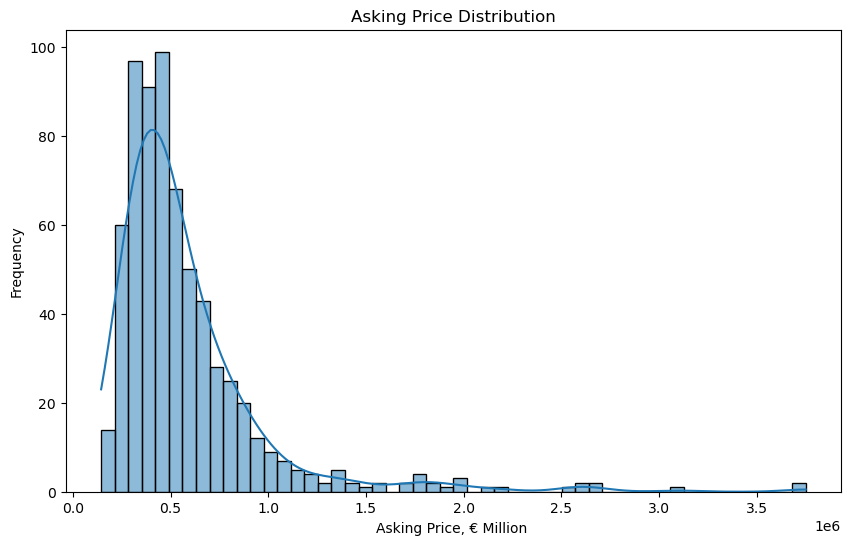

In [35]:
# --- Visualizations and Insights ---

# 1. Distribution of Asking Prices
plt.figure(figsize = (10,6))
sns.histplot(nl_data_final['Asking_Price'], kde=True)
plt.title('Asking Price Distribution')
plt.xlabel('Asking Price, € Million ')
plt.ylabel('Frequency')
plt.show()

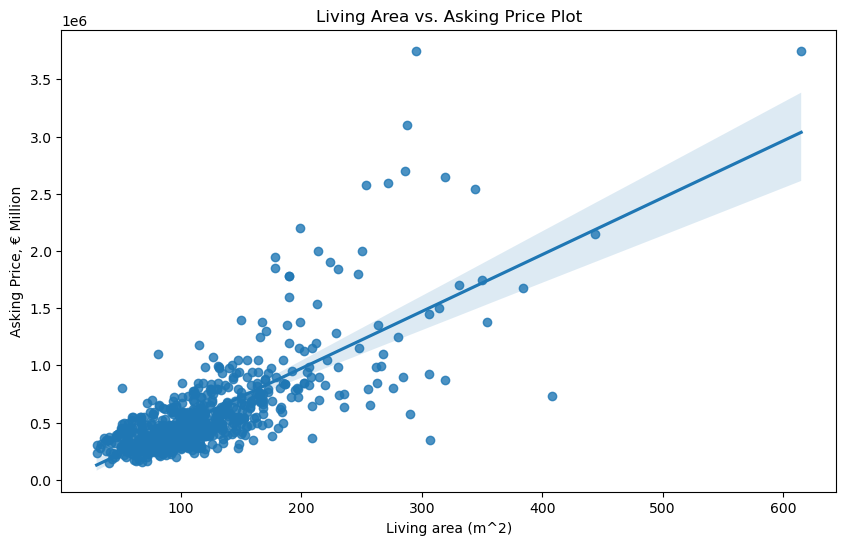

In [37]:
# 2. Relationship between Living Area Size and Asking Price
plt.figure(figsize = (10,6))
sns.regplot(x='Living_AreaSize(m2)', y = 'Asking_Price', data = nl_data_final)
plt.title('Living Area vs. Asking Price Plot')
plt.xlabel('Living area (m^2)')
plt.ylabel('Asking Price, € Million')
plt.show()

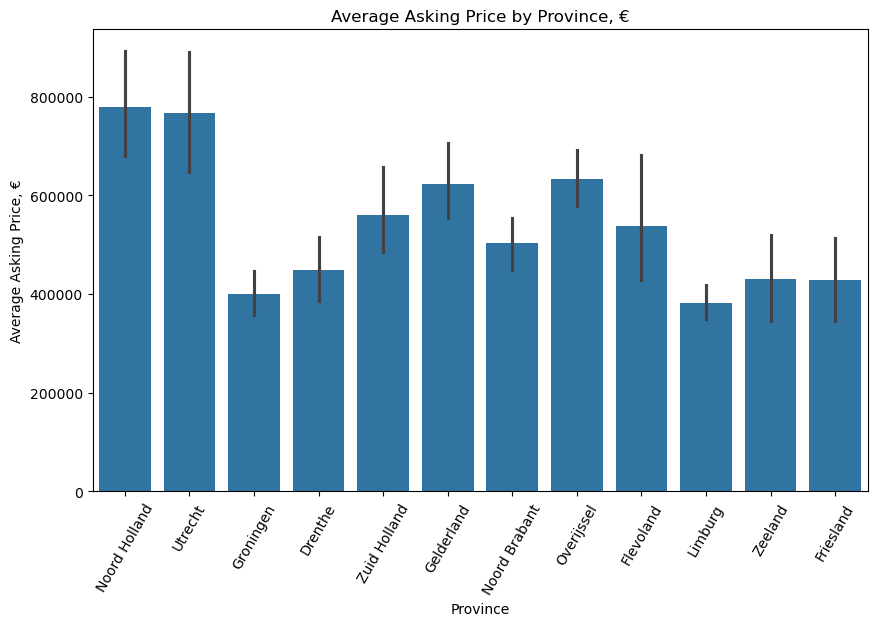

In [39]:
# 3. Average Asking Price by Province
plt.figure(figsize = (10,6))
sns.barplot(x = 'Provincie', y = 'Asking_Price', data = nl_data_final)
plt.title('Average Asking Price by Province, €')
plt.xlabel('Province')
plt.ylabel('Average Asking Price, €')
plt.xticks(rotation = 60)
plt.show()

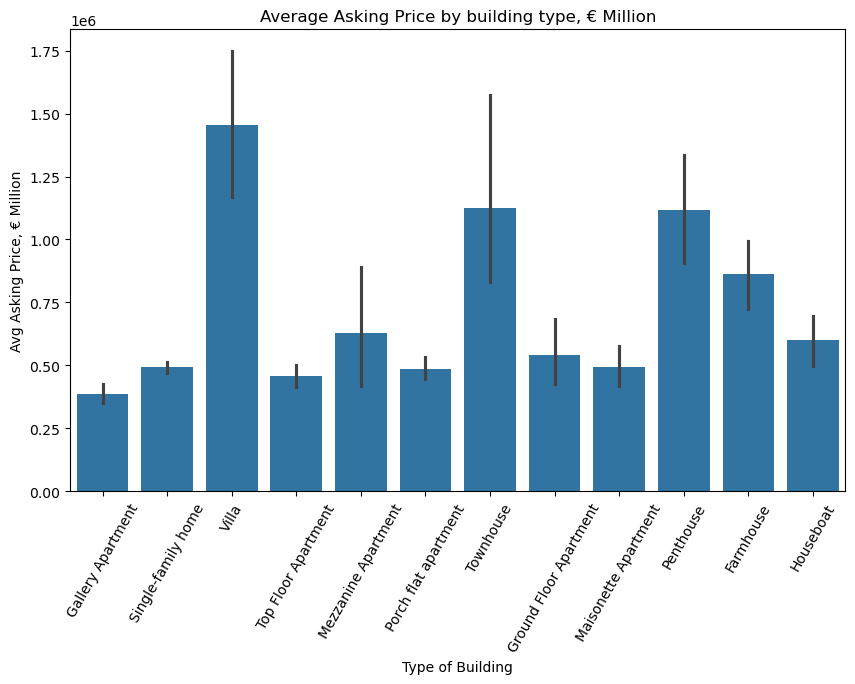

In [41]:
# 4. Average Asking Price by building type
plt.figure(figsize = (10,6))
sns.barplot(x = 'Type_of_building', y = 'Asking_Price', data = nl_data_final)
plt.title('Average Asking Price by building type, € Million')
plt.xlabel('Type of Building')
plt.ylabel('Avg Asking Price, € Million')
plt.xticks(rotation = 60)
plt.show()

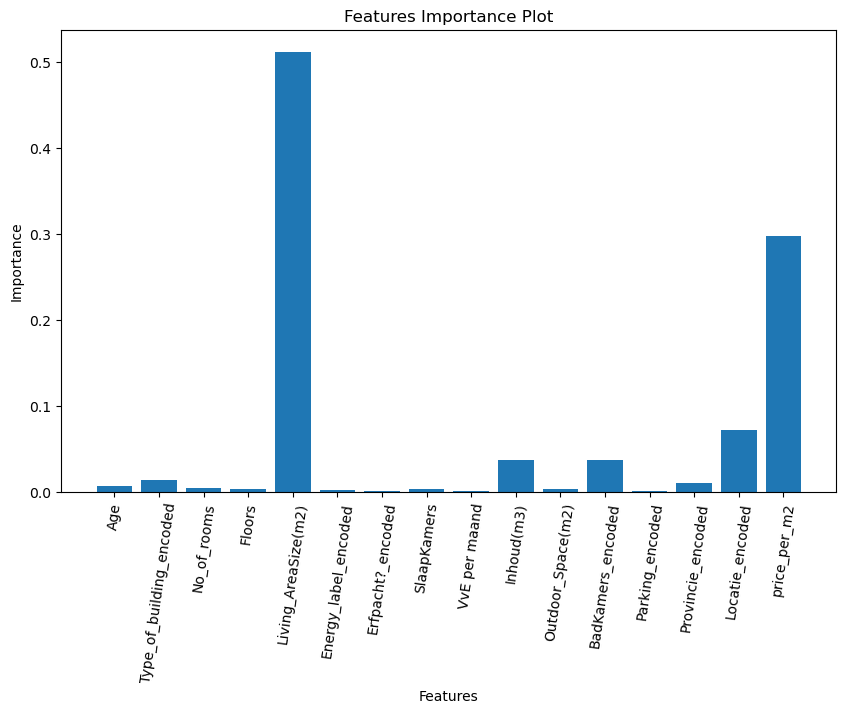

In [43]:
# 5. Feature Importance Plot
features_importance = NL_Model_RF.feature_importances_
plt.figure(figsize = (10,6))
plt.bar(features, features_importance)
plt.title('Features Importance Plot')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation = 82)
plt.show()

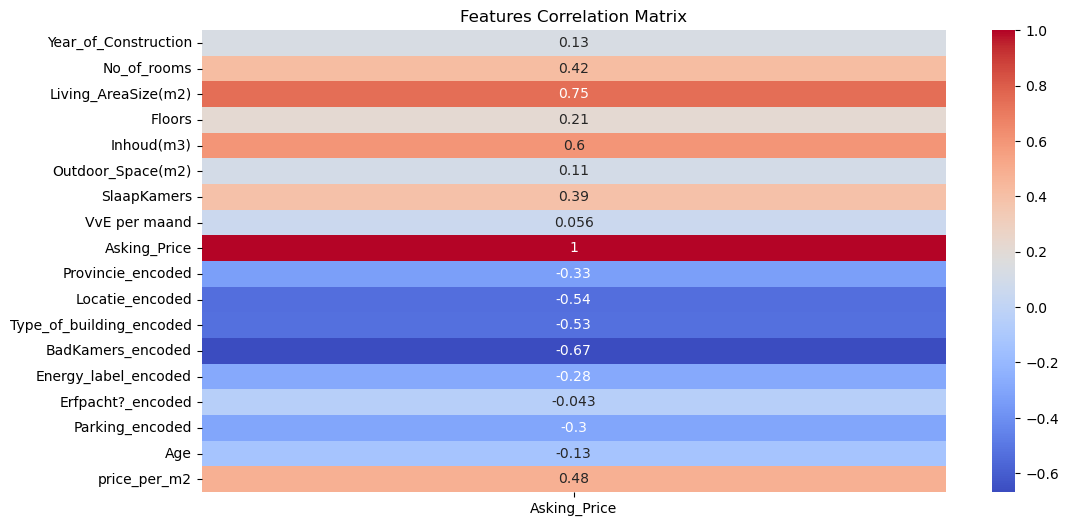

Encoded Columns Legend: 

Provincie : 
 {'Noord Holland': 0, 'Utrecht': 1, 'Overijssel': 2, 'Gelderland': 3, 'Zuid Holland': 4, 'Flevoland': 5, 'Noord Brabant': 6, 'Drenthe': 7, 'Zeeland': 8, 'Friesland': 9, 'Groningen': 10, 'Limburg': 11}
Type_of_building : 
 {'Villa': 0, 'Townhouse': 1, 'Penthouse': 2, 'Farmhouse': 3, 'Mezzanine Apartment': 4, 'Houseboat': 5, 'Ground Floor Apartment': 6, 'Maisonette Apartment': 7, 'Single-family home': 8, 'Porch flat apartment': 9, 'Top Floor Apartment': 10, 'Gallery Apartment': 11}
BadKamers : 
 {'4 Bathrooms 3 Toilets': 0, '2 Bathrooms 3 Toilets': 1, '3 Bathrooms 2 Toilets': 2, '1 Bathroom 3 Toilets': 3, '2 Bathrooms 2 Toilets': 4, '3 Bathrooms 1 Toilet': 5, '2 Bathrooms': 6, '2 Bathrooms 1 Toilet': 7, '5 Bathrooms 1 Toilet': 8, '1 Bathroom 2 Toilets': 9, '1 Bathroom 1 Toilet': 10, '1 Bathroom': 11, '1 Bathroom ': 12}
Energy_label : 
 {'A+': 0, 'A+++': 1, 'A++': 2, 'A++++': 3, 'A': 4, 'G': 5, 'A+++++': 6, 'E': 7, 'B': 8, 'C': 9, 'D': 10, 'F': 11}
E

In [79]:
# 6. Correlation Matrix
plt.figure(figsize=(12, 6))
corr_matrix = nl_data_final.drop(columns=['Adres','Provincie','Locatie','Type_of_Construction','Type_of_building',
                                        'Storage_Space','BadKamers','Energy_label','Erfpacht?','Parking']).corr()
asking_price_corr = corr_matrix['Asking_Price']
sns.heatmap(asking_price_corr.to_frame(), annot=True, cmap='coolwarm')   
plt.title('Features Correlation Matrix')
plt.show()
# Print encoded values with their corresponding categories
print("Encoded Columns Legend: \n")
for col in ['Provincie', 'Type_of_building', 'BadKamers', 'Energy_label', 'Erfpacht?', 'Parking']:
    mean_prices = nl_data_final.groupby(col)['Asking_Price'].mean()
    sorted_types = mean_prices.sort_values(ascending = False).index
    col_mapping = {btype: i for i, btype in enumerate(sorted_types)}
    print(col, ": \n", col_mapping )
# print("Energy Label: \n", el_mapping)
# print("Erfpacht: \n", erf_mapping)
# print("Badkamers: \n", badkamers_mapping)
# print("Parking Type: \n",parking_mapping)
# print("Province: \n", provincie_mapping)